<a href="https://colab.research.google.com/github/sriksmachi/ishara/blob/main/gesture_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [3]:
# !pip install scipy
# !pip install Pillow
# !pip install imageio
# !pip install tensorflow
# !pip install matplotlib
#!pip install opencv-python
#!pip install gdown

In [4]:
import numpy as np
import os
import imageio
import datetime
import os
import cv2
import pathlib
import gdown
from scipy import misc
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [5]:
import random as rn
from keras import backend as K
import tensorflow as tf

rn.seed(30)
np.random.seed(30)
tf.compat.v1.random.set_random_seed(30)

In [6]:
print(tf.__version__)

2.4.1


In [7]:
!python --version

Python 3.7.10


In [8]:
!nvidia-smi

Thu Apr 29 18:08:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load Data

In [9]:
!gdown 'https://drive.google.com/uc?export=download&id=1kl5iauN3iVCPnSHys0xvTUnAd41CNu3S'

Downloading...
From: https://drive.google.com/uc?export=download&id=1kl5iauN3iVCPnSHys0xvTUnAd41CNu3S
To: /content/Project_data.zip
1.71GB [00:29, 57.2MB/s]


In [ ]:
!unzip /content/Project_data.zip

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [9]:
## Use this to load the data if the data exists on gdrive and using google colab for 

data_dir="Project_data/"
data_dir_train = "Project_data/train/"
data_dir_val = 'Project_data/val/'

train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())


## Visualization

Let us plot some sample images and run some transformations on the image so see the impact.

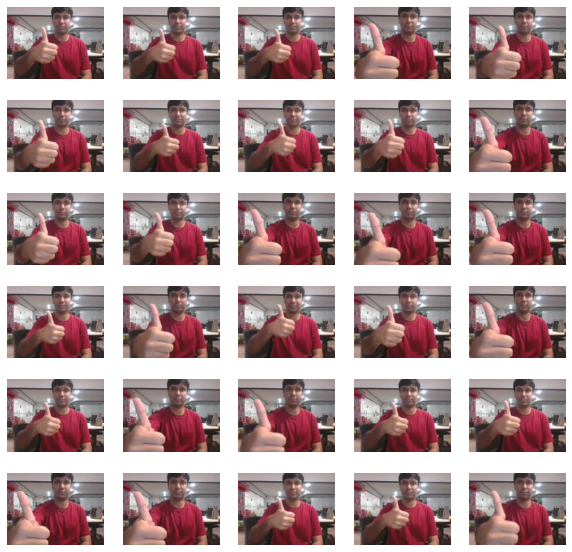

In [10]:



random_sequence = train_doc[np.random.randint(len(train_doc))].strip().split(';')[0]+'/'
images = os.listdir(data_dir_train + random_sequence)
# Create a code to visualize one instance of all the 30 images present in the sequence
plt.figure(figsize=(10, 10))
i = 0
random_images = []
for img in images:
  ax = plt.subplot(6, 5, i + 1)
  i = i + 1
  random_images.append(os.path.join(data_dir_train, random_sequence, img))
  img_bgr = cv2.imread(os.path.join(data_dir_train, random_sequence, img))
  img_mp = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # This is needed because opencv uses BGR convention and matplotlib uses RGB
  imgplot= plt.imshow(img_mp)
  plt.axis("off")
  plt.plot()

(120, 160, 3)


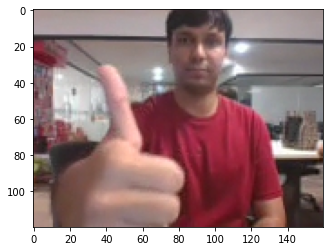

In [11]:
# Random Image - Original
random_image = random_images[np.random.randint(30)]
image_bgr = cv2.imread(random_image)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
print(image_bgr.shape)

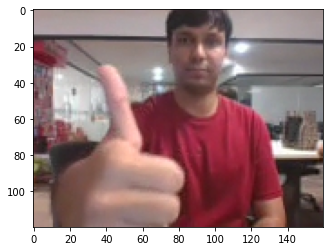

In [12]:
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

(110, 140, 3)


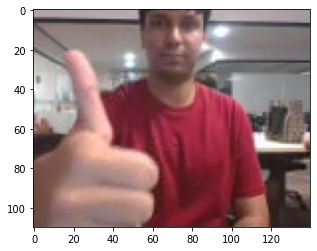

In [13]:
## Cropped Image Sample
y=10 # height, cropping more from the height for most of the images the data is at the center
x=20
h=img_bgr.shape[0]
w=img_bgr.shape[1]
crop_img = img_bgr[y:y+h, x:x+w]
plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))
print(crop_img.shape)

(120, 120, 3)


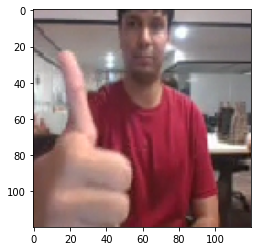

In [14]:
# Resize Image Sample
dim = (120, 120) # keeping the width extended
resized_img = cv2.resize(crop_img, dim, interpolation = cv2.INTER_NEAREST)
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
print(resized_img.shape)

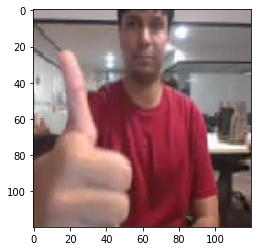

In [15]:
# Normalized Image
plt.imshow(cv2.cvtColor(cv2.normalize(resized_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), cv2.COLOR_BGR2RGB))

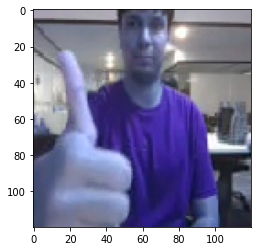

In [16]:
plt.imshow(resized_img/255)

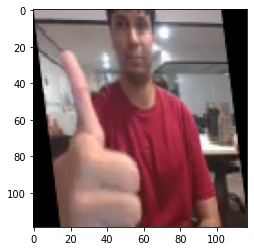

In [17]:
# Affine transformation
r = resized_img
rows, cols = resized_img.shape[:2]
src_points = np.float32([[0,0], [cols-1,0], [0,rows-1]])
dst_points = np.float32([[0,0], [int((np.random.uniform(low=0.8, high=0.9))*(cols-1)),0], [int((np.random.uniform(low=0.1, high=0.3))*(cols-1)),rows-1]])
affine_matrix = cv2.getAffineTransform(src_points, dst_points)
img_output = cv2.warpAffine(resized_img, affine_matrix, (cols,rows))

# when sheer transformation is applied we get the additional black regions which are not required, the below code reducesmoves them
gray = cv2.cvtColor(img_output,cv2.COLOR_BGR2GRAY)
x0, y0 = np.argwhere(gray > 0).min(axis=0)
x1, y1 = np.argwhere(gray > 0).max(axis=0) 
cropped=img_output[x0:x1,y0:y1,:]
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))                  

## Generator

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [10]:
import time

def crop_image(image, size = (10,20)):
     # cropping the image
    h = image.shape[0]
    w = image.shape[1]
    y=size[1]
    x=size[0]
    crop_img = image[y:y+h, x:x+w]
    return crop_img

def affine_transform(image):
    rows, cols = image.shape[:2]
    src_points = np.float32([[0,0], [cols-1,0], [0,rows-1]])
    dst_points = np.float32([[0,0], [int((np.random.uniform(low=0.8, high=0.9))*(cols-1)),0], [int((np.random.uniform(low=0.1, high=0.3))*(cols-1)),rows-1]])
    affine_matrix = cv2.getAffineTransform(src_points, dst_points)
    img_output = cv2.warpAffine(image, affine_matrix, (cols,rows))
    # when sheer transformation is applied we get the additional black regions which are not required, the below code reducesmoves them
    gray = cv2.cvtColor(img_output,cv2.COLOR_BGR2GRAY)
    x0, y0 = np.argwhere(gray > 0).min(axis=0)
    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
    cropped=img_output[x0:x1,y0:y1,:]
    return cropped

def normalize_minmax(image_resized, batch_data, folder, idx):
    # print(folder,dim,idx,image_resized.shape)
    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
    return batch_data   

def crop_resize_normalize(image,batch_data, folder, idx,dim,cropped=False):
    
    #crop the images and resize them. Note that the images are of 2 different shape 
    #and the conv3D will throw error if the inputs in a batch have different shapes
    # if not cropped: # in augmentation cases the image is already cropped
    #     image = crop_image(image)

    image_resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    # using min max normalization.
    batch_data = normalize_minmax(image_resized, batch_data, folder, idx)
    return batch_data


def create_batch_data(t, source_path, img_idx, batch_num, batch_size,dim=(120,120),data_augmentation=False, pending_batches=0):
    # print('batch_',batch_num,'batch_size_',batch_size)
    start_time = time.time()
    x = len(img_idx)
    y = dim[0]
    z = dim[1]

    folders = pending_batches if pending_batches > 0 else batch_size
    batch_data = np.zeros((folders,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((folders, 5)) # iterate over the batch_size

    if (data_augmentation): # if data augmentation is required
        augmented_batch_data = np.zeros((folders,x,y,z,3))

    for folder in range(folders):
        # print('folders:',folders,'folder',folder,'batch_num',batch_num,'batch_size',batch_size,'pending_batches',pending_batches)
        imgs = os.listdir(source_path+'/'+ t[folder + (batch_num*batch_size)].split(';')[0]) # read all the images in the folder

        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    
            image = cv2.imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+
                           imgs[item]).astype(np.float32)
        
            batch_data = crop_resize_normalize(image, batch_data, folder, idx, dim)

            if (data_augmentation):
                transformed_image = affine_transform(image)
                augmented_batch_data = crop_resize_normalize(transformed_image, augmented_batch_data, folder, idx, dim, cropped=True)
                    
        batch_labels[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1

    if (data_augmentation):
        # print('augmenting data...')
        batch_data = np.concatenate([batch_data, augmented_batch_data])
        batch_labels = np.concatenate([batch_labels, batch_labels]) # because labels are still teh same

    return batch_data, batch_labels

def generator(source_path, folder_list, dim=(120,120), batch_size=30, ablation=None,samples=[5,10,15], augment=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size, 'dim=', dim)
    x = len(samples) # number of taken from each video
    img_idx = samples #create a list of image numbers you want to use for a particular video
    y = dim[0] # image dim, its height * width
    z = dim[1] # image dim

    while True:
        
        if ablation is not None: 
            t = np.random.permutation(folder_list[:ablation])
        else:
            t = np.random.permutation(folder_list)
            
        num_batches =  len(t) // batch_size # calculate the number of batches
        
        for batch_num in range(num_batches): # we iterate over the number of batches

            ## create one batch of data
            batch_data, batch_labels = create_batch_data(t, source_path, img_idx, batch_num, batch_size,dim,data_augmentation=augment)

            yield batch_data, batch_labels 
            
        # The length of the folder list could leave some residue folders, the below code deals with it
        # Number of pending batches
        pending_batches = len(t) % batch_size
        
        if (pending_batches > 0):
            # print('pending batches',pending_batches,'num_batches:',num_batches)

            ## create one batch of data
            pending_batch_data,  pending_batch_labels= create_batch_data(t, source_path, img_idx, num_batches, batch_size,dim, augment,pending_batches)
        
            yield pending_batch_data, pending_batch_labels
            

# g = generator(data_dir_train, train_doc, samples=[1,2,3,4,5,6,7,8,9,0], augment=False)
# b = next(g)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model

#### Objective

Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### 3D Convolution

We will build the model using 3D Convolution Architecture

In [13]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras import optimizers

activation = 'relu'

#write your model here
samples_per_image=15

# Building a 3 D Convolution model.
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation=activation, input_shape=(samples_per_image,120,120,3)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(2, 2, 2), activation=activation))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(256, activation=activation))
model.add(Dense(256, activation=activation))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [35]:
optimiser =  'sgd' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 13, 118, 118, 32)  2624      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 6, 59, 59, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 5, 58, 58, 64)     16448     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 29, 29, 64)     0         
_________________________________________________________________
flatten (Flatten)            (None, 107648)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               27558144  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [33]:
# Reusable function to run 3d convolution
def run_3d_convolution(num_epochs, batch_size, dim=(120,120), ablation_size=None, callbacks_list=[], augmentation=False, samples=15):
  idx=np.round(np.linspace(0,29,samples)).astype(int)
  print('='*100)
  if ablation_size is None:
    num_train_sequences = len(train_doc)
    num_val_sequences = len(val_doc)
  else:
    num_train_sequences = len(train_doc[:ablation_size])
    num_val_sequences = len(val_doc[:ablation_size])

  print('# training sequences =', num_train_sequences)
  print('# validation sequences =', num_val_sequences)
  print ('# epochs =', num_epochs)

  if (num_train_sequences%batch_size) == 0:
     steps_per_epoch = int(num_train_sequences/batch_size)
  else:
     steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
      validation_steps = int(num_val_sequences/batch_size)
  else:
      validation_steps = (num_val_sequences//batch_size) + 1

  print('steps_per_epoch: {}, validation_steps: {}'.format(steps_per_epoch, validation_steps))

  train_generator = generator(data_dir_train, train_doc, dim=dim, batch_size=batch_size, ablation=ablation_size, samples=idx, augment=augmentation)
  val_generator = generator(data_dir_val, val_doc, dim=dim, batch_size=batch_size, ablation=ablation_size, samples=idx)

  print('='*100)

  history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
  return history

#### Ablation Experiment

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`. 
We will fit the model with 1 epoch just to validate if the model is working.
Notice I have not added any callbacks yet, we will do it in the later sections

In [34]:
# Experiment Parameters
ablation_size=100
num_epochs = 1
batch_size=10
dim=(120,120)

run_3d_convolution(num_epochs, batch_size, dim, ablation_size,callbacks_list=[])

# training sequences = 100
# validation sequences = 100
# epochs = 1
steps_per_epoch: 10, validation_steps: 10
Source path =  Project_data/train/ ; batch size = 10 dim= (120, 120)


ValueError: ignored

The model seems to be working well, there are no errors. 

#### Overfitting on training data. 

Let us overfit on the training data to see if the model is able to learn from the data. We are going to use less data and run for more epochs and see if the model is able to improve the accuracy and reduce the loss.

In [24]:
ablation_size=300
batch_size=30
num_epochs=10
dim=(120,120)

run_3d_convolution(num_epochs, batch_size, dim, ablation_size)

# training sequences = 300
# validation sequences = 100
# epochs = 10
steps_per_epoch: 10, validation_steps: 4
Source path =  Project_data/train/ ; batch size = 30 dim= (120, 120)
Epoch 1/10
10/10 [==============================] - 12s 1s/step - loss: 1.5909 - categorical_accuracy: 0.2267 - val_loss: 1.5672 - val_categorical_accuracy: 0.2600
Epoch 2/10
10/10 [==============================] - 12s 1s/step - loss: 1.5727 - categorical_accuracy: 0.2733 - val_loss: 1.5367 - val_categorical_accuracy: 0.2900
Epoch 3/10
10/10 [==============================] - 11s 1s/step - loss: 1.5549 - categorical_accuracy: 0.2767 - val_loss: 1.5380 - val_categorical_accuracy: 0.4100
Epoch 4/10
10/10 [==============================] - 11s 1s/step - loss: 1.5348 - categorical_accuracy: 0.3333 - val_loss: 1.5172 - val_categorical_accuracy: 0.4200
Epoch 5/10
10/10 [==============================] - 12s 1s/step - loss: 1.4998 - categorical_accuracy: 0.3800 - val_loss: 1.4909 - val_categorical_accuracy: 0.3000


The training loss reduced and accuracy increased, the model is able to learn well. There is significant gap between the training and validation accuracy so we have successfully overfit the model.

#### Callbacks

Here we define few callbacks which we will use later when we fit the complete model.

In [11]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.2f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001, verbose=1, mode='min')

tensorboard = TensorBoard(
  log_dir='.\logs',
  histogram_freq=1,
  write_images=True
)

ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

callbacks_list = [tensorboard, ES, checkpoint, LR]

In [12]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

#### Experiment with full data

In [44]:
#Experiment Parameters
ablation_size=None
batch_size=30
num_epochs=10
dim=(120,120)

run_3d_convolution(num_epochs, batch_size, dim, ablation_size,[])

# training sequences = 663
# validation sequences = 100
# epochs = 1
steps_per_epoch: 23, validation_steps: 4
Source path =  Project_data/train/ ; batch size = 30 dim= (120, 120)
23/23 [==============================] - 22s 992ms/step - loss: 1.4981 - categorical_accuracy: 0.3394 - val_loss: 1.5981 - val_categorical_accuracy: 0.2600

Epoch 00001: val_loss improved from inf to 1.59809, saving model to model_init_2021-04-2912_02_16.934921/model-00001-1.49808-0.33937-1.60-0.26000.h5


#### Adding one more Conv Layer and increase the images per folder

In [28]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
samples_per_image=20
activation='relu'

# Building a 3 D Convolution model.
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation=activation, input_shape=(samples_per_image,120, 120,3)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation=activation))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# learnings from https://machinelearningmastery.com/introduction-to-1x1-convolutions-to-reduce-the-complexity-of-convolutional-neural-networks/
model.add(Conv3D(128, kernel_size=(2, 2, 2), activation=activation))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(256, activation=activation))
model.add(Dense(256, activation=activation))
model.add(Dense(5, activation='softmax'))

optimiser =  'sgd' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_2 (Conv3D)            (None, 18, 118, 118, 32)  2624      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 9, 59, 59, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 57, 57, 64)     55360     
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 3, 28, 28, 64)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 2, 27, 27, 128)    65664     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 1, 13, 13, 128)    0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)            

##### Overfitting on training data

In [29]:
ablation_size=300
batch_size=30
num_epochs=5
dim=(120,120)

run_3d_convolution(num_epochs, batch_size, dim, ablation_size, samples=20)

# training sequences = 300
# validation sequences = 100
# epochs = 5
steps_per_epoch: 10, validation_steps: 4
Source path =  Project_data/train/ ; batch size = 30 dim= (120, 120)
Epoch 1/5
10/10 [==============================] - 16s 2s/step - loss: 1.6086 - categorical_accuracy: 0.2208 - val_loss: 1.5891 - val_categorical_accuracy: 0.2300
Epoch 2/5
10/10 [==============================] - 16s 2s/step - loss: 1.5879 - categorical_accuracy: 0.2464 - val_loss: 1.5789 - val_categorical_accuracy: 0.2800
Epoch 3/5
10/10 [==============================] - 16s 2s/step - loss: 1.5757 - categorical_accuracy: 0.2517 - val_loss: 1.5982 - val_categorical_accuracy: 0.1800
Epoch 4/5
10/10 [==============================] - 15s 2s/step - loss: 1.5575 - categorical_accuracy: 0.2844 - val_loss: 1.5711 - val_categorical_accuracy: 0.2500
Epoch 5/5
10/10 [==============================] - 15s 2s/step - loss: 1.5608 - categorical_accuracy: 0.3164 - val_loss: 1.5509 - val_categorical_accuracy: 0.2800


The training loss reduced and accuracy increased, the model is able to learn well. There is significant gap between the training and validation accuracy so we have successfully overfit the model.

##### Experiment with full data

In [30]:
#Experiment Parameters
ablation_size=None
batch_size=30
num_epochs=15
dim=(120,120)

run_3d_convolution(num_epochs, batch_size, dim, ablation_size,callbacks_list, samples=20)

# training sequences = 663
# validation sequences = 100
# epochs = 15
steps_per_epoch: 23, validation_steps: 4
Source path =  Project_data/train/ ; batch size = 30 dim= (120, 120)
Epoch 1/15
23/23 [==============================] - 29s 1s/step - loss: 1.5634 - categorical_accuracy: 0.2760 - val_loss: 1.6209 - val_categorical_accuracy: 0.2300
Epoch 2/15
23/23 [==============================] - 29s 1s/step - loss: 1.5406 - categorical_accuracy: 0.3243 - val_loss: 1.7159 - val_categorical_accuracy: 0.2500
Epoch 3/15
23/23 [==============================] - 28s 1s/step - loss: 1.5219 - categorical_accuracy: 0.3152 - val_loss: 1.7351 - val_categorical_accuracy: 0.2300
Epoch 4/15
23/23 [==============================] - 28s 1s/step - loss: 1.4978 - categorical_accuracy: 0.3469 - val_loss: 1.5980 - val_categorical_accuracy: 0.3500
Epoch 5/15
23/23 [==============================] - 28s 1s/step - loss: 1.4567 - categorical_accuracy: 0.3635 - val_loss: 1.5218 - val_categorical_accuracy: 0.3100


#### Applying Batch Normalization

In [31]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
samples_per_image=30

# Building a 3 D Convolution model.
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(samples_per_image,120, 120,3)))
model.add(BatchNormalization()),
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(2, 2, 2), activation='relu'))
model.add(BatchNormalization()),
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# learnings from https://machinelearningmastery.com/introduction-to-1x1-convolutions-to-reduce-the-complexity-of-convolutional-neural-networks/
model.add(Conv3D(128, kernel_size=(1, 1, 1), activation='relu'))
model.add(BatchNormalization()),
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser =  'sgd' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 28, 118, 118, 32)  2624      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 118, 118, 32)  128       
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 14, 59, 59, 32)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 13, 58, 58, 64)    16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 58, 58, 64)    256       
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 6, 29, 29, 64)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 29, 29, 64)    

##### Ablation Experiment

In [32]:
# Experiment Parameters
ablation_size=300
num_epochs = 3
batch_size=30
dim=(120,120)

run_3d_convolution(num_epochs, batch_size, dim, ablation_size,samples=30)

# training sequences = 300
# validation sequences = 100
# epochs = 3
steps_per_epoch: 10, validation_steps: 4
Source path =  Project_data/train/ ; batch size = 30 dim= (120, 120)
Epoch 1/3
10/10 [==============================] - 25s 3s/step - loss: 6.1781 - categorical_accuracy: 0.2350 - val_loss: 1.6464 - val_categorical_accuracy: 0.2300
Epoch 2/3
10/10 [==============================] - 24s 3s/step - loss: 1.4675 - categorical_accuracy: 0.3382 - val_loss: 1.5960 - val_categorical_accuracy: 0.2500
Epoch 3/3
10/10 [==============================] - 23s 3s/step - loss: 1.3676 - categorical_accuracy: 0.4022 - val_loss: 1.5512 - val_categorical_accuracy: 0.2500


##### Experiment with full data

In [33]:
#Experiment Parameters
ablation_size=None
batch_size=30
num_epochs=15
dim=(120,120)

run_3d_convolution(num_epochs, batch_size, dim, ablation_size,callbacks_list,samples=30)

# training sequences = 663
# validation sequences = 100
# epochs = 15
steps_per_epoch: 23, validation_steps: 4
Source path =  Project_data/train/ ; batch size = 30 dim= (120, 120)
Epoch 1/15
23/23 [==============================] - 44s 2s/step - loss: 1.1049 - categorical_accuracy: 0.5566 - val_loss: 2.0819 - val_categorical_accuracy: 0.2200
Epoch 2/15
23/23 [==============================] - 43s 2s/step - loss: 0.9295 - categorical_accuracy: 0.6214 - val_loss: 2.9268 - val_categorical_accuracy: 0.1600
Epoch 3/15
23/23 [==============================] - 42s 2s/step - loss: 0.5932 - categorical_accuracy: 0.7722 - val_loss: 3.8359 - val_categorical_accuracy: 0.2000
Epoch 4/15
23/23 [==============================] - 42s 2s/step - loss: 0.4526 - categorical_accuracy: 0.8401 - val_loss: 4.2583 - val_categorical_accuracy: 0.1600
Epoch 5/15
23/23 [==============================] - 43s 2s/step - loss: 0.2842 - categorical_accuracy: 0.8989 - val_loss: 4.2107 - val_categorical_accuracy: 0.1600


#### Adding Dropout Layer

I also converted the model to a function to experiment with different sample sizes, height and width. Notice that the batch normalization is removed because the model does not seem to be learning well with batch normalization applied. Hence here we apply only drop outs and l2 regularization

In [38]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from keras import optimizers

def create_conv3d_model(samples, height, width):

  # Building a 3 D Convolution model.
  model = Sequential()
  model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(samples,height, width,3)))
  model.add(BatchNormalization()),
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(32, kernel_size=(2, 2, 2), activation='relu',padding='same'))
  model.add(BatchNormalization()),
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(64, kernel_size=(2, 2, 2), activation='relu',padding='same')) 
  model.add(BatchNormalization()),
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(128, kernel_size=(2,2,2), activation='relu',padding='same'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(0.4)),
  
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.4)),

  model.add(Dense(5, activation='softmax'))

  optimiser =  optimizers.Adam()
  model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  return model

##### Ablation Experiments

In [35]:
#Experiment Parameters without augmentation
ablation_size=None
batch_size=30
num_epochs=3
dim=(120,120)
samples=16

model = create_conv3d_model(samples,dim[0],dim[1])
model.summary()
run_3d_convolution(num_epochs, batch_size, dim, ablation_size, callbacks_list, augmentation=False, samples=samples)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_29 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
batch_normalization_30 (Batc (None, 8, 60, 60, 32)     128       
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 4, 30, 30, 32)     0         
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 4, 30, 30, 64)   

In [36]:
#Experiment Parameters without augmentation
ablation_size=None
batch_size=30
num_epochs=3
dim=(120,120)
samples=30

model = create_conv3d_model(samples,dim[0],dim[1])
model.summary()
run_3d_convolution(num_epochs, batch_size, dim, ablation_size, callbacks_list, augmentation=False, samples=samples)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_40 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_32 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_40 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_41 (Conv3D)           (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
batch_normalization_33 (Batc (None, 15, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_41 (MaxPooling (None, 7, 30, 30, 32)     0         
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 7, 30, 30, 64)   

In [39]:
#Experiment Parameters without augmentation
ablation_size=None
batch_size=20
num_epochs=3
dim=(120,120)
samples=20

model = create_conv3d_model(samples,dim[0],dim[1])
model.summary()
run_3d_convolution(num_epochs, batch_size, dim, ablation_size, callbacks_list, augmentation=False, samples=samples)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_48 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_38 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_48 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_49 (Conv3D)           (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
batch_normalization_39 (Batc (None, 10, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_49 (MaxPooling (None, 5, 30, 30, 32)     0         
_________________________________________________________________
conv3d_50 (Conv3D)           (None, 5, 30, 30, 64)   

In [37]:
#Experiment Parameters without augmentation
ablation_size=None
batch_size=30
num_epochs=3
dim=(100,100)
samples=30

model = create_conv3d_model(samples,dim[0],dim[1])
model.summary()
run_3d_convolution(num_epochs, batch_size, dim, ablation_size, callbacks_list, augmentation=False, samples=samples)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_44 (Conv3D)           (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization_35 (Batc (None, 30, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_44 (MaxPooling (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_45 (Conv3D)           (None, 15, 50, 50, 32)    4128      
_________________________________________________________________
batch_normalization_36 (Batc (None, 15, 50, 50, 32)    128       
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 7, 25, 25, 32)     0         
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 7, 25, 25, 64)   

In [34]:
#Experiment Parameters with augmentation
ablation_size=None
batch_size=30
num_epochs=3
dim=(120,120)
samples=20

model = create_conv3d_model(samples,dim[0],dim[1])
model.summary()
run_3d_convolution(num_epochs, batch_size, dim, ablation_size, callbacks_list, augmentation=True, samples=samples)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_32 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_26 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_32 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
batch_normalization_27 (Batc (None, 10, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 5, 30, 30, 32)     0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 5, 30, 30, 64)   

In [40]:
#Experiment Parameters with augmentation
ablation_size=None
batch_size=30
num_epochs=3
dim=(120,120)
samples=30

model = create_conv3d_model(samples,dim[0],dim[1])
model.summary()
run_3d_convolution(num_epochs, batch_size, dim, ablation_size, callbacks_list, augmentation=True, samples=samples)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_52 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_41 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_52 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_53 (Conv3D)           (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
batch_normalization_42 (Batc (None, 15, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_53 (MaxPooling (None, 7, 30, 30, 32)     0         
_________________________________________________________________
conv3d_54 (Conv3D)           (None, 7, 30, 30, 64)   

From the above experiments we learn that the model learns better with increased samples per image, reduced dimensions have less impact on accuracy. 

Since the model seems to be improving, increasing the epochs and images per sequence. The below configuration worked better among all in the ablation experiments above.

# training sequences = 663
# validation sequences = 100
# epochs = 30
steps_per_epoch: 23, validation_steps: 4
Source path =  Project_data/train/ ; batch size = 30 dim= (120, 120)
Epoch 1/30
23/23 [==============================] - 63s 3s/step - loss: 5.1341 - categorical_accuracy: 0.2154 - val_loss: 3.5065 - val_categorical_accuracy: 0.3100

Epoch 00001: val_loss did not improve from 1.59809
Epoch 2/30
23/23 [==============================] - 59s 3s/step - loss: 3.2948 - categorical_accuracy: 0.3017 - val_loss: 3.1991 - val_categorical_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 1.59809
Epoch 3/30
23/23 [==============================] - 58s 3s/step - loss: 2.7147 - categorical_accuracy: 0.4240 - val_loss: 3.3821 - val_categorical_accuracy: 0.2000

Epoch 00003: val_loss did not improve from 1.59809
Epoch 4/30
23/23 [==============================] - 59s 3s/step - loss: 2.3299 - categorical_accuracy: 0.4459 - val_loss: 3.1179 - val_categorical_accuracy: 0.2200

Epoch 0

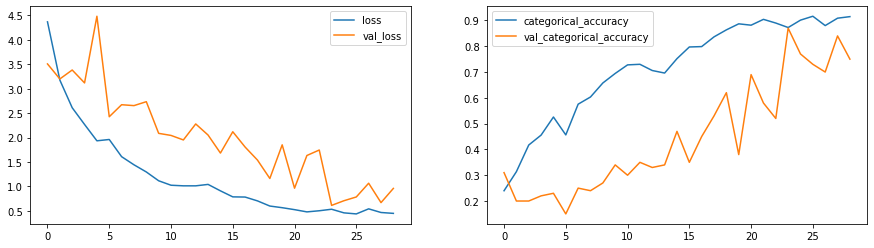

In [47]:
#Experiment Parameters with augmentation
ablation_size=None
batch_size=30
num_epochs=30
dim=(120,120)
samples=20

model = create_conv3d_model(samples,dim[0],dim[1])
history = run_3d_convolution(num_epochs, batch_size, dim, ablation_size, callbacks_list, augmentation=True, samples=samples)
plot(history)

# training sequences = 663
# validation sequences = 100
# epochs = 30
steps_per_epoch: 34, validation_steps: 5
Source path =  Project_data/train/ ; batch size = 20 dim= (120, 120)
Epoch 1/30
34/34 [==============================] - 87s 3s/step - loss: 5.5732 - categorical_accuracy: 0.2264 - val_loss: 3.5019 - val_categorical_accuracy: 0.3800
Epoch 2/30
34/34 [==============================] - 100s 3s/step - loss: 3.2968 - categorical_accuracy: 0.2952 - val_loss: 3.0870 - val_categorical_accuracy: 0.2200
Epoch 3/30
34/34 [==============================] - 94s 3s/step - loss: 2.7493 - categorical_accuracy: 0.3867 - val_loss: 2.9620 - val_categorical_accuracy: 0.3000
Epoch 4/30
34/34 [==============================] - 87s 3s/step - loss: 2.3718 - categorical_accuracy: 0.4094 - val_loss: 2.7173 - val_categorical_accuracy: 0.2100
Epoch 5/30
34/34 [==============================] - 86s 3s/step - loss: 2.1754 - categorical_accuracy: 0.4005 - val_loss: 3.1991 - val_categorical_accuracy: 0.1900

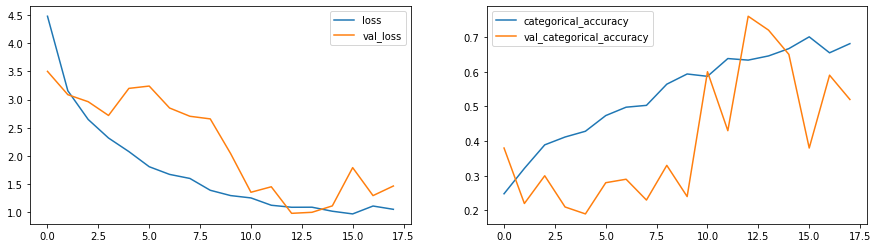

In [46]:
#Experiment Parameters with augmentation
ablation_size=None
batch_size=20
num_epochs=30
dim=(120,120)
samples=30

model = create_conv3d_model(samples,dim[0],dim[1])
history = run_3d_convolution(num_epochs, batch_size, dim, ablation_size, callbacks_list, augmentation=True, samples=samples)
plot(history)

Increasing the sample size to 30 did not increase any accuracy hence we will use the model with 20 samples only.

The below configuration caused OOM exception
- Beyond 30 batch size
- 160*160 image size.

##### Experiment with full data

### CNN + RNN Model using Transfer Learning
The following architectures are trained and tested
- MobileNet + GRU with/without dropouts
- Resnet 50 + LSTM with/without dropouts

In [26]:
# Reusable function to run CRNN convolution
def run_crnn(num_epochs, batch_size, dim=(120,120), ablation_size=None, callbacks_list=[], augmentation=False, samples=15):
  idx=np.round(np.linspace(0,29,samples)).astype(int)
  print('='*100)
  if ablation_size is None:
    num_train_sequences = len(train_doc)
    num_val_sequences = len(val_doc)
  else:
    num_train_sequences = len(train_doc[:ablation_size])
    num_val_sequences = len(val_doc[:ablation_size])

  print('# training sequences =', num_train_sequences)
  print('# validation sequences =', num_val_sequences)
  print ('# epochs =', num_epochs)

  if (num_train_sequences%batch_size) == 0:
     steps_per_epoch = int(num_train_sequences/batch_size)
  else:
     steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
      validation_steps = int(num_val_sequences/batch_size)
  else:
      validation_steps = (num_val_sequences//batch_size) + 1

  print('steps_per_epoch: {}, validation_steps: {}'.format(steps_per_epoch, validation_steps))

  train_generator = generator(data_dir_train, train_doc, dim=dim, batch_size=batch_size, ablation=ablation_size, samples=idx, augment=augmentation)
  val_generator = generator(data_dir_val, val_doc, dim=dim, batch_size=batch_size, ablation=ablation_size, samples=idx)

  print('='*100)

  history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
  return history

In [14]:
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
from tensorflow.keras.layers import Flatten,Dense,TimeDistributed,GRU,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential

In [15]:
from keras.applications import MobileNet
from keras.applications.resnet50 import ResNet50
from keras.layers import LSTM

def create_crnn_model(samples, x, y, rnncells = 8, type='mobilenet_withoutdropouts'):
  
  if type == 'mobilenet_withoutdropouts':
  
    mobileNet_transferlearning = MobileNet(weights='imagenet',include_top=False, input_shape=(x,y,3))
  
    for layer in mobileNet_transferlearning.layers[:-10]:
     mobileNet_transferlearning.trainable=False

    model = Sequential()
    model.add(TimeDistributed(mobileNet_transferlearning,input_shape=(samples,x,y,3)))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(rnncells,return_sequences=False))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(5,activation='softmax'))

    optimiser =  optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model;
  
  if type == 'mobilenet_withdropouts':
  
    mobileNet_transferlearning = MobileNet(weights='imagenet',include_top=False, input_shape=(x,y,3))
    for layer in mobileNet_transferlearning.layers[:-10]:
       mobileNet_transferlearning.trainable=False

    model = Sequential()
    model.add(TimeDistributed(mobileNet_transferlearning,input_shape=(samples,x,y,3)))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(rnncells,return_sequences=False))
    model.add(Dropout(.4))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(.4))
    model.add(Dense(5,activation='softmax'))

    optimiser =  optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model;

  if type == 'resnet_withoutdropouts':

    resnet_transferlearning = ResNet50(include_top=False, weights='imagenet', input_shape=(x,y,3))
    for layer in resnet_transferlearning.layers[:-10]:
       resnet_transferlearning.trainable=False

    model = Sequential()
    model.add(TimeDistributed(resnet_transferlearning,input_shape=(samples,x,y,3)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(rnncells,return_sequences=False))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(5,activation='softmax'))

    optimiser =  optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model;

  if type == 'resnet_withdropouts':

    resnet_transferlearning = ResNet50(include_top=False, weights='imagenet', input_shape=(x,y,3))
    for layer in resnet_transferlearning.layers[:-10]:
       resnet_transferlearning.trainable=False

    model = Sequential()
    model.add(TimeDistributed(resnet_transferlearning,input_shape=(samples,x,y,3)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(rnncells,return_sequences=False))
    model.add(Dropout(.4))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(.4))
    model.add(Dense(5,activation='softmax'))

    optimiser =  optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model;

#### Ablation Experiments with Mobile net + GRU

In [14]:
#Experiment Parameters with augmentation
ablation_size=300
batch_size=20
num_epochs=3
dim=(120,120)
samples=20

model = create_crnn_model(samples,dim[0],dim[1])
model.summary()
run_crnn(num_epochs, batch_size, dim, ablation_size, [], augmentation=True, samples=samples)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 9216)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 221424    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2304      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1285      
Total params: 3,453,877
Trainable params: 225,013
Non-trainable params: 3,228,864
_________________________________________________________________
# training sequences = 300
# validation sequences = 100
# epochs = 3
steps_per_epoch: 15, validation_ste

In [15]:
#Experiment Parameters with augmentation
ablation_size=300
batch_size=30
num_epochs=3
dim=(120,120)
samples=30

model = create_crnn_model(samples,dim[0],dim[1])
model.summary()
run_crnn(num_epochs, batch_size, dim, ablation_size, [], augmentation=True, samples=samples)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 9216)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 8)                 221424    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2304      
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 1285      
Total params: 3,453,877
Trainable params: 225,013
Non-trainable params: 3,228,864
_________________________________________________________________
# training sequences = 300
# validation sequences = 100
# epochs = 3
steps_per_epoch: 10, validation_ste

The model learns better with higher batch size and more samples per video. Adding dropouts to address overfitting

In [21]:
#Experiment Parameters with augmentation
ablation_size=300
batch_size=30
num_epochs=3
dim=(120,120)
samples=30

model = create_crnn_model(samples,dim[0],dim[1], grucells=512, type='mobilenet_withdropouts')
model.summary()
run_crnn(num_epochs, batch_size, dim, ablation_size, [], augmentation=True, samples=samples)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_15 (TimeDis (None, 30, 9216)          0         
_________________________________________________________________
gru_7 (GRU)                  (None, 512)               14945280  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 5)                

#### Experiments with Full data

# training sequences = 663
# validation sequences = 100
# epochs = 25
steps_per_epoch: 23, validation_steps: 4
Source path =  Project_data/train/ ; batch size = 30 dim= (120, 120)
Epoch 1/25
23/23 [==============================] - 95s 4s/step - loss: 2.0580 - categorical_accuracy: 0.2114 - val_loss: 1.3300 - val_categorical_accuracy: 0.5100

Epoch 00001: val_loss improved from inf to 1.33003, saving model to model_init_2021-04-2915_29_33.110495/model-00001-1.85347-0.23454-1.33-0.51000.h5
Epoch 2/25
23/23 [==============================] - 84s 4s/step - loss: 1.4818 - categorical_accuracy: 0.3745 - val_loss: 1.1718 - val_categorical_accuracy: 0.6400

Epoch 00002: val_loss improved from 1.33003 to 1.17182, saving model to model_init_2021-04-2915_29_33.110495/model-00002-1.42332-0.40422-1.17-0.64000.h5
Epoch 3/25
23/23 [==============================] - 84s 4s/step - loss: 1.3036 - categorical_accuracy: 0.4595 - val_loss: 1.0042 - val_categorical_accuracy: 0.6300

Epoch 00003: val_loss i

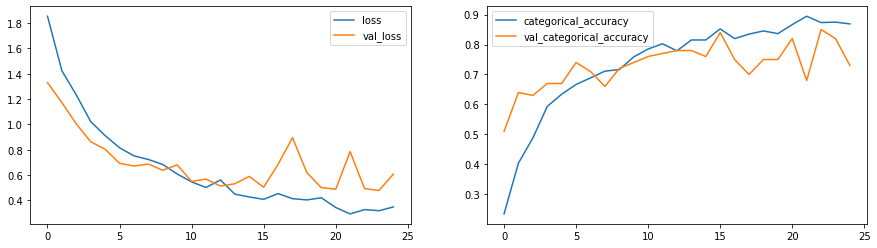

In [22]:
#Experiment Parameters with augmentation
ablation_size=None
batch_size=30
num_epochs=25
dim=(120,120)
samples=30

model = create_crnn_model(samples,dim[0],dim[1], grucells=256, type='mobilenet_withdropouts')
history = run_crnn(num_epochs, batch_size, dim, ablation_size, callbacks_list, augmentation=True, samples=samples)
plot(history)

#### Ablation Experiments with Resnet + LSTM

In [39]:
#Experiment Parameters with augmentation
ablation_size=300
batch_size=30
num_epochs=3
dim=(120,120)
samples=30

model = create_crnn_model(samples,dim[0],dim[1], rnncells=512, type='resnet_withoutdropouts')
model.summary()
run_crnn(num_epochs, batch_size, dim, ablation_size, [], augmentation=True, samples=samples)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_28 (TimeDis (None, 30, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_29 (TimeDis (None, 30, 32768)         0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 512)               68159488  
_________________________________________________________________
dense_20 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 1285      
Total params: 91,879,813
Trainable params: 68,292,101
Non-trainable params: 23,587,712
_________________________________________________________________
# training sequences = 300
# validation sequences = 100
# epochs = 3
steps_per_epoch: 10, validati

In [40]:
#Experiment Parameters with augmentation
ablation_size=300
batch_size=20
num_epochs=3
dim=(120,120)
samples=20

model = create_crnn_model(samples,dim[0],dim[1], rnncells=512, type='resnet_withoutdropouts')
model.summary()
run_crnn(num_epochs, batch_size, dim, ablation_size, [], augmentation=True, samples=samples)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_30 (TimeDis (None, 20, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_31 (TimeDis (None, 20, 32768)         0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 512)               68159488  
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 1285      
Total params: 91,879,813
Trainable params: 68,292,101
Non-trainable params: 23,587,712
_________________________________________________________________
# training sequences = 300
# validation sequences = 100
# epochs = 3
steps_per_epoch: 15, validati

In [42]:
#Experiment Parameters with augmentation
ablation_size=300
batch_size=20
num_epochs=3
dim=(120,120)
samples=20

model = create_crnn_model(samples,dim[0],dim[1], rnncells=512, type='resnet_withdropouts')
model.summary()
run_crnn(num_epochs, batch_size, dim, ablation_size, [], augmentation=True, samples=samples)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 20, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_33 (TimeDis (None, 20, 32768)         0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 512)               68159488  
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 5)               

Since the model with less samples and batch size worked better, below we will do a full experiment

#### Experiments with full data

In [ ]:
#Experiment Parameters with augmentation
ablation_size=None
batch_size=20
num_epochs=25
dim=(120,120)
samples=20

model = create_crnn_model(samples,dim[0],dim[1], rnncells=512, type='resnet_withoutdropouts')
model.summary()
history = run_crnn(num_epochs, batch_size, dim, ablation_size, [], augmentation=True, samples=samples)
plot(history)

In [ ]:
#Experiment Parameters with augmentation
ablation_size=None
batch_size=20
num_epochs=25
dim=(120,120)
samples=20

model = create_crnn_model(samples,dim[0],dim[1], rnncells=512, type='resnet_withdropouts')
model.summary()
history = run_crnn(num_epochs, batch_size, dim, ablation_size, [], augmentation=True, samples=samples)
plot(history)

### Custom CNN + RNN

In [36]:

def create_custom_crnn_model(samples, x, y, rnncells = 8, dropouts = False):
  
  if (dropouts):
    cnn = Sequential()
    cnn.add(Conv2D(32, (3, 3), padding='same',input_shape=(x,y,3)))
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(32, (3, 3)))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Dropout(0.25))

    cnn.add(Conv2D(64, (3, 3), padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(64, (3, 3)))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Dropout(0.25))

    cnn.add(Flatten())
    cnn.add(Dense(512))
    cnn.add(Activation('relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(256))

    model = Sequential()
    model.add(TimeDistributed(cnn,input_shape=(samples,x,y,3)))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(rnncells,return_sequences=False)) # using GRU here because they have less parameters compared to LSTM
    model.add(Dense(256, activation='relu'))
    model.add(Dense(5,activation='softmax'))

    optimiser =  optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model;

  else:
    cnn = Sequential()
    cnn.add(Conv2D(32, (3, 3), padding='same', input_shape=(x, y, 3)))
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(32, (3, 3)))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Conv2D(64, (3, 3), padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(64, (3, 3)))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Flatten())
    cnn.add(Dense(512))
    cnn.add(Activation('relu'))
    cnn.add(Dense(256))
    model = Sequential()
    model.add(TimeDistributed(cnn,input_shape=(samples,x,y,3)))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(rnncells,return_sequences=False)) # using GRU here because they have less parameters compared to LSTM
    model.add(Dense(256, activation='relu'))
    model.add(Dense(5,activation='softmax'))

    optimiser =  optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

#### Ablation Experiments

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, 20, 256)           25887520  
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 256)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 512)               1182720   
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 1285      
Total params: 27,202,853
Trainable params: 27,202,853
Non-trainable params: 0
_________________________________________________________________
# training sequences = 300
# validation sequences = 100
# epochs = 3
steps_per_epoch: 15, validation_steps:

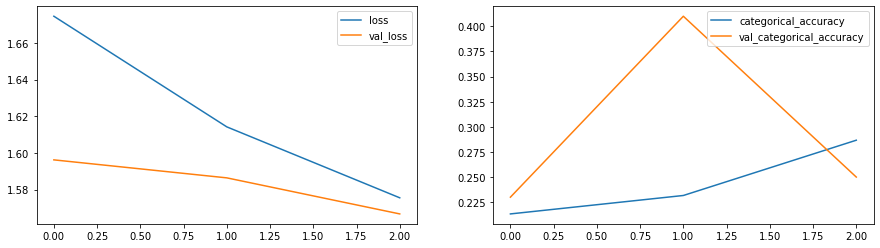

In [29]:
#Experiment Parameters with augmentation
ablation_size=300
batch_size=20
num_epochs=3
dim=(120,120)
samples=20

model = create_custom_crnn_model(samples,dim[0],dim[1], rnncells=512, dropouts = False)
model.summary()
history = run_crnn(num_epochs, batch_size, dim, ablation_size, [], augmentation=True, samples=samples)
plot(history)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 20, 256)           25887520  
_________________________________________________________________
time_distributed_11 (TimeDis (None, 20, 256)           0         
_________________________________________________________________
gru_5 (GRU)                  (None, 512)               1182720   
_________________________________________________________________
dense_26 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 1285      
Total params: 27,202,853
Trainable params: 27,202,853
Non-trainable params: 0
_________________________________________________________________
# training sequences = 300
# validation sequences = 100
# epochs = 3
steps_per_epoch: 10, validation_steps:

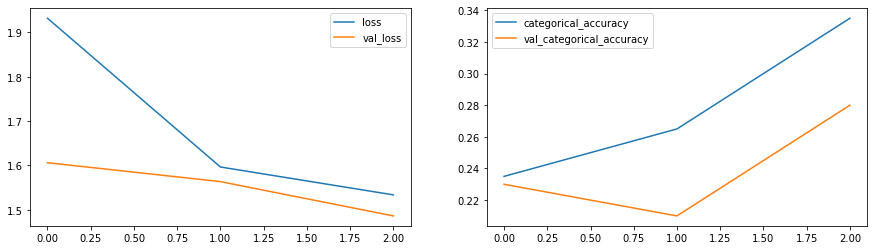

In [31]:
#Experiment Parameters with augmentation
ablation_size=300
batch_size=30
num_epochs=3
dim=(120,120)
samples=20 # OOM raised for samples = 30

model = create_custom_crnn_model(samples,dim[0],dim[1], rnncells=512, dropouts = False)
model.summary()
history = run_crnn(num_epochs, batch_size, dim, ablation_size, [], augmentation=True, samples=samples)
plot(history)

#### Experiments with Full data

In [40]:
#Experiment Parameters with augmentation
ablation_size=None
batch_size=30
num_epochs=25
dim=(120,120)
samples=20 # OOM raised for samples = 30

model = create_custom_crnn_model(samples,dim[0],dim[1], rnncells=512, dropouts = True)
model.summary()
history = run_crnn(num_epochs, batch_size, dim, ablation_size, [], augmentation=True, samples=samples)
plot(history)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 20, 256)           25887520  
_________________________________________________________________
time_distributed_15 (TimeDis (None, 20, 256)           0         
_________________________________________________________________
gru_7 (GRU)                  (None, 512)               1182720   
_________________________________________________________________
dense_34 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_35 (Dense)             (None, 5)                 1285      
Total params: 27,202,853
Trainable params: 27,202,853
Non-trainable params: 0
_________________________________________________________________
# training sequences = 663
# validation sequences = 100
# epochs = 25
steps_per_epoch: 23, validation_steps

KeyboardInterrupt: ignored

## Final Model

In [51]:
import time
from keras.models import load_model
model = load_model('model_init_2021-04-2912_02_16.934921/model-00024-0.53115-0.87255-0.61-0.87000.h5')
test_generator = generator(data_dir_val, val_doc, dim=dim, batch_size=batch_size, ablation=ablation_size, samples=list(range(0,30,1)))
test_data, test_labels = next(test_generator)
predictions = model.predict(test_data)

Source path =  Project_data/val/ ; batch size = 30 dim= (120, 120)
Actuals....


In [52]:
print(np.argmax(test_labels, axis=1))
print(np.argmax(predictions, axis=1))

[4 2 1 0 0 4 1 3 4 0 1 2 1 2 2 1 4 3 2 2 2 2 2 1 4 2 2 3 0 0]
[4 0 1 0 0 4 1 3 4 0 1 2 1 2 0 1 4 3 2 0 0 2 4 1 4 2 2 3 0 0]
